In [40]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-5-nano")
llm.invoke("hi")

AIMessage(content='Hi there! How can I help today? I can do things like:\n\n- Answer questions or explain concepts\n- Help with writing (emails, essays, resumes, captions)\n- Draft or debug code\n- Translate or summarize text\n- Plan things (meals, trips, schedules)\n- Brainstorm ideas or topics\n- Chat or play word games\n\nTell me what you need or pick a category, and we’ll dive in.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 353, 'prompt_tokens': 7, 'total_tokens': 360, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 256, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D07xUX5EnqIPa1RCtqwcfvsf7Z76m', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bdc06-5b6b-75e2-ac4e-b22c4febb397-

In [41]:
email_input = {
    "from" : "user@gmail.com",
    "to" : "netflix@support.com",
    "subject": "Netflix Account Unable to Access",
    "thread" : """Dear Netflix Support Team,

I hope this message finds you well. I am writing to report an issue I am currently experiencing with my Netflix account.

Issue: Unable to Access Account

I have been unable to access my Netflix account recently. When I attempt to log in, I encounter difficulties that prevent me from accessing the service.

Could you please assist me in resolving this matter? I would appreciate any guidance on:
- Steps to regain access to my account
- Verification of my account status
- Any security concerns that might be affecting my access

I am available to provide any additional information you may need to help resolve this issue promptly.

Thank you for your attention to this matter. I look forward to your response.
"""
}



In [42]:
from pydantic import BaseModel, Field
from typing import Literal
class RouterSchema(BaseModel):
    """Analyse the email and classify it based on the comtent"""
    reasoning:str = Field(description="Step by step reasoning of the email classification")
    classification:Literal["ignore", "notify", "respond"] = Field(description="classify the email based on the content")

In [43]:
llm_with_router = llm.with_structured_output(RouterSchema)

In [44]:
from operator import itemgetter
sender, receiver, subject, thread = itemgetter("from", "to", "subject", "thread")(email_input)

In [45]:
from rich.markdown import Markdown

user_prompt = f"""Classify the email

Sender : {sender}

Receiver : {receiver}

Subject : {subject}

Thread : {thread}

"""

Markdown(user_prompt)

Classify the email                                                                                                 

Sender : user@gmail.com                                                                                            

Receiver : netflix@support.com                                                                                     

Subject : Netflix Account Unable to Access                                                                         

Thread : Dear Netflix Support Team,                                                                                

I hope this message finds you well. I am writing to report an issue I am currently experiencing with my Netflix    
account.                                                                                                           

Issue: Unable to Access Account                                                                                    

I have been unable to access my Netflix account recently. When I attempt to log in, I encounter difficulties that  
prevent me from accessing the service.                                                                             

Could you please assist me in resolving this matter? I would appreciate any guidance on:                           

 • Steps to regain access to my account                                                                            
 • Verification of my account status                                                                               
 • Any security concerns that might be affecting my access                                                         

I am available to provide any additional information you may need to help resolve this issue promptly.             

Thank you for your attention to this matter. I look forward to your response.

In [46]:
llm_with_router.invoke(user_prompt)

RouterSchema(reasoning='The email is a user-submitted support request about Netflix account access, asking for steps to regain access, verification of account status, and potential security concerns. It is not spam or a notification to forward elsewhere, and it requires a direct response from support to resolve the issue.', classification='respond')

In [47]:
from langgraph.graph import MessagesState

class State(MessagesState):
    email_input:dict
    classification_decision:Literal["ignore", "notify", "respond"]

In [48]:
from operator import itemgetter
from langgraph.graph import END
from langgraph.types import Command
def traige_router(state:State):
    email_input = state["email_input"]
    # destructure the email
    sender, receiver, subject, thread = itemgetter("from", "to", "subject", "thread")(email_input)
    # create user prompt
    u_prompt = user_prompt.format(sender=sender, receiver=receiver, subject=subject, thread=thread)
    ## invoke the llm
    response = llm_with_router.invoke(u_prompt)

    if response.classification == "ignore":
        goto = END
        update = {
            "classification_decison" : "ignore"
        }
    elif response.classification == "notify":
        goto=END
        update = {
            "classification_decision" : "notify"
        }
    elif response.classification == "respond":
        goto= "response_agent"
        update = {
            "classification_decision" : "respond",
            "messages": {
                "role": "user",
                "content": u_prompt
            }
        }
    else:
        return ValueError("Invalid value")
    
    return Command(goto=goto, update=update)
    
    

    


In [53]:
from langgraph.graph import START ,END, StateGraph

def call_llm(state:State):
    out = llm.invoke(state["messages"])
    return {"messages": out}




agent = StateGraph(State)

#adds node
agent.add_node("call_llm", call_llm)
# add edge
agent.add_edge(START, "call_llm")

agent = agent.compile()


In [54]:
## define tools
from langchain_core.tools import tool

@tool
def raise_ticket(customer_email:str, content:str):
    """raise a ticket for customer complaint"""
    return f"Ticker has been Raised for customer : {customer_email}"


@tool
def send_email(to:str, subject:str, thread:str):
    """Send email to customer"""
    return f"Email has been send to : {to}"




In [51]:
support_tools = [raise_ticket, send_email]
support_tools_by_name = {tool.name: tool for tool in support_tools}

llm = llm.bind_tools(support_tools, tool_choice="any", parallel_tool_calls=False)


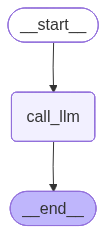

In [52]:
from IPython.display import Image, display 

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [62]:
out = agent.invoke({"messages": user_prompt})
out

{'messages': [HumanMessage(content='Classify the email\n\nSender : user@gmail.com\n\nReceiver : netflix@support.com\n\nSubject : Netflix Account Unable to Access\n\nThread : Dear Netflix Support Team,\n\nI hope this message finds you well. I am writing to report an issue I am currently experiencing with my Netflix account.\n\nIssue: Unable to Access Account\n\nI have been unable to access my Netflix account recently. When I attempt to log in, I encounter difficulties that prevent me from accessing the service.\n\nCould you please assist me in resolving this matter? I would appreciate any guidance on:\n- Steps to regain access to my account\n- Verification of my account status\n- Any security concerns that might be affecting my access\n\nI am available to provide any additional information you may need to help resolve this issue promptly.\n\nThank you for your attention to this matter. I look forward to your response.\n\n\n', additional_kwargs={}, response_metadata={}, id='3f82beff-e1d3

In [63]:
out["messages"][-1].tool_calls

[{'name': 'raise_ticket',
  'args': {'customer_email': 'user@gmail.com',
   'content': 'Dear Netflix Support Team,\n\nI hope this message finds you well. I am writing to report an issue I am currently experiencing with my Netflix account.\n\nIssue: Unable to Access Account\n\nI have been unable to access my Netflix account recently. When I attempt to log in, I encounter difficulties that prevent me from accessing the service.\n\nCould you please assist me in resolving this matter? I would appreciate any guidance on:\n- Steps to regain access to my account\n- Verification of my account status\n- Any security concerns that might be affecting my access\n\nI am available to provide any additional information you may need to help resolve this issue promptly.\n\nThank you for your attention to this matter. I look forward to your response.'},
  'id': 'call_5Pmta9M4lvrBP7R5X3I9v5t3',
  'type': 'tool_call'}]